In [45]:
import numpy as np

from matplotlib import pyplot as plt

import covidsim.seir as seir
import covidsim.seir_smp as seir_smp
from covidsim.utils import plot_path, plot_paths

plt.rcParams["figure.figsize"] = (16, 9)  # set default figure size

# COVID-19 Model
> Based on [Andrew Atkeson](https://sites.google.com/site/andyatkeson/)'s papers.

The model can be adjusted to fit other countries realities.

### Works used:
- [Atkeson, Andrew. What Will Be the Economic Impact of COVID-19 in the US? Rough Estimates of Disease Scenarios. w26867, National Bureau of Economic Research, março de 2020, p. w26867. DOI.org (Crossref), https://doi.org/10.3386/w26867.](https://www.nber.org/papers/w26867)
- [Atkeson, Andrew. Behavior and the Dynamics of Epidemics. w28760, National Bureau of Economic Research, maio de 2021, p. w28760. DOI.org (Crossref), https://doi.org/10.3386/w28760.](https://drive.google.com/file/d/16BvFUK2KFMG_bK_6qZDuXhCFrZQLs4SZ/view)
- [Atkeson, Andrew. A Parsimonious Behavioral SEIR Model of the 2020 COVID Epidemic in the United States and the United Kingdom. w28434, National Bureau of Economic Research, fevereiro de 2021, p. w28434. DOI.org (Crossref), https://doi.org/10.3386/w28434.](https://drive.google.com/file/d/18oeUouZ5um9s5dZo-IAHDCiz7NP1Z8BC/view)
- [Lockdowns and GDP Is there a tradeoff?](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view)
- [Atkeson, Andrew G., et al. “Behavior and the Transmission of COVID-19”. AEA Papers and Proceedings, vol. 111, maio de 2021, p. 356–60. DOI.org (Crossref), https://doi.org/10.1257/pandp.20211064.](https://drive.google.com/file/d/1-J-xG0HyjhOfxJjJ6y0rQx1iOacsSmRQ/view)

---

## The _SEIR_ model

The model _SEIR_ is a *[compartmental model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)*, which is a very general model technique. This kind of model is often applied
to the [mathematical modelling of infectious diseases](https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease).
The intent of these models are to predict things such as a disease sparseness, epidemics duration, or total number of infected.

This model consists of four compartments:
- **S**: The number of susceptible (without immunity) individuals;
- **E**: The number of exposed individuals;
- **I**: The number of infected individuals;
- **R**: The number of recovered (or dead, in this case) individuals.

These compartments, in this simulation, have its pace set over time as follows:

$
\large
\begin{aligned}
\beta_t &= R_t \gamma \\[5pt]
\frac{\text{d}S}{\text{d}t} &= −\beta_t \frac{S}{N}I \\[5pt]
\frac{\text{d}E}{\text{d}t} &= \beta_t \frac{S}{N}I - \sigma E \\[5pt]
\frac{\text{d}I}{\text{d}t} &= \sigma E - \gamma I \\[5pt]
\frac{\text{d}R}{\text{d}t} &= \gamma I
\end{aligned}
$

In these equations:
- $ \beta_t $ is the _transmission rate_.
- $ R_t $ is the _effective reproduction number_ (one individual can infect X others).
- $ N $ is the _population_ normalized to one, so the same model could be applied to any population without altering
the equation.
- $ \sigma $ is the _infection rate_.
- $ \gamma $ is the _recovery rate_.

The parameter $ R_t $ allow the implementation of scenarios where social distance and other mitigation measures are put
in practice with variable strength. It can be achieved with the following:

$
\large
\begin{aligned}
R_{1t} &= R_{1,0} \text{exp}(-\eta_1 t) + (1 - \text{exp}(-\eta_1 t)) \bar{R_1} \\[5pt]
R_{2t} &= R_{2,0} \text{exp}(-\eta_2 t) + (1 - \text{exp}(-\eta_2 t)) \bar{R_2} \\[5pt]
R_t &= \frac{R_{1t} + R_{2t}}{2}
\end{aligned}
$

 <br />

In this case, $ R_0 $ is the initial value of $ R_t $ and is expressed as $ (R_{1t} + R_{2t})/2 $

---

### In cases where $ R_t $ is constant, the following simplified system may be used:

$
\large
\begin{equation}
\dot{s}(t) = - \, \beta(t) \: s(t) \: i(t) \\
\dot{e}(t) = \beta(t) \: s(t) \: i(t) - \sigma e(t) \\
\dot{i}(t) = \sigma e(t) - \gamma i(t)
\end{equation}
$

In these equations:
- $ \dot{y} $ represents the time derivative $ \dfrac{\mathrm{d}y}{\mathrm{d}t} $

Some other considerations:
- There is no need to model the fraction $ r $ in state $ R $ since the other three states form a partition.
Actually, the $ r $ fraction of the population is $ r = 1 - s - e - i $
- The _cumulative cases_ (the ones who have or have had contracted the illness) formula will be $ c = i + r $
- The whole population will eventually become infected if $ \beta(t) $ is positive and $ i(0) > 0 $

These equations can be writen in vector form:

\begin{align}
\qquad\dot{x} = \mathrm{dsei}(x, t)   \qquad   x := (s, e, i)
\end{align}

---

### Please note
- $ R_t $ and $ R(t) $ are different from $ R $.
- To produce a constant value of $ R_t $ in the non-simplified model, $ \bar{R_1} = \bar{R_2} = R_{1,0} = R_{2,0} = R_0 $ may be set.
Furthermore, the values of $ n_1 $ and $ n_2 $ are arbitrary in this case and can be set to 1.
- I will be using both methods (original and simplified) when possible.

In [46]:
population_size: float = 3.3e8  # USA

incubation_period: float = 1 / 5.2  # In days
illness_duration: float = 1 / 18  # In days

In [47]:
# initial S, E, I
i_0 = 1e-7
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

# S, E, I vector
x_0_o = s_0, e_0, i_0, 0
x_0_s = s_0, e_0, i_0

***
# Case Simulation (USA)
> Scenario simulation

In [48]:
t_len = 550  # In days. Approximately 18 months
grid_size = 1000  # Samples to generate
t_vec = np.linspace(0, t_len, grid_size)

## Scenario 1: Constant _R_0 Case

In [49]:
r0_vals = np.linspace(3.0, 1.6, 7)
labels = [f'$R0 = {r:.2f}$' for r in r0_vals]
i_paths_o, c_paths_o = [], []
i_paths_s, c_paths_s = [], []

for r in r0_vals:
    i_path_o, c_path_o = seir.solve_path(incubation_period, illness_duration, x_0_o, t_vec, r, r, r, r)
    i_path_s, c_path_s = seir_smp.solve_path(r, incubation_period, illness_duration, t_vec, x_0_s)
    i_paths_o.append(i_path_o)
    c_paths_o.append(c_path_o)
    i_paths_s.append(i_path_s)
    c_paths_s.append(i_path_s)

### Current cases as a fraction of the population

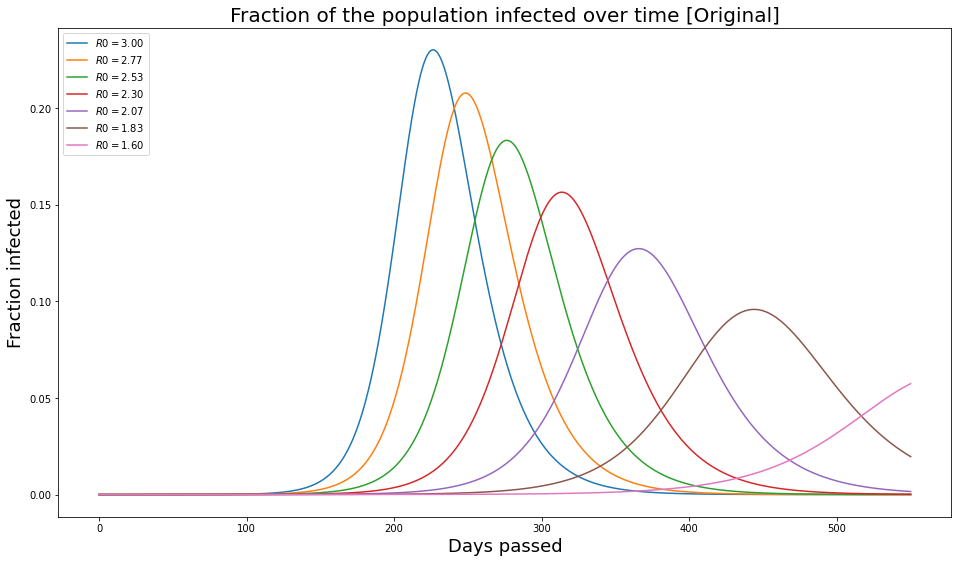

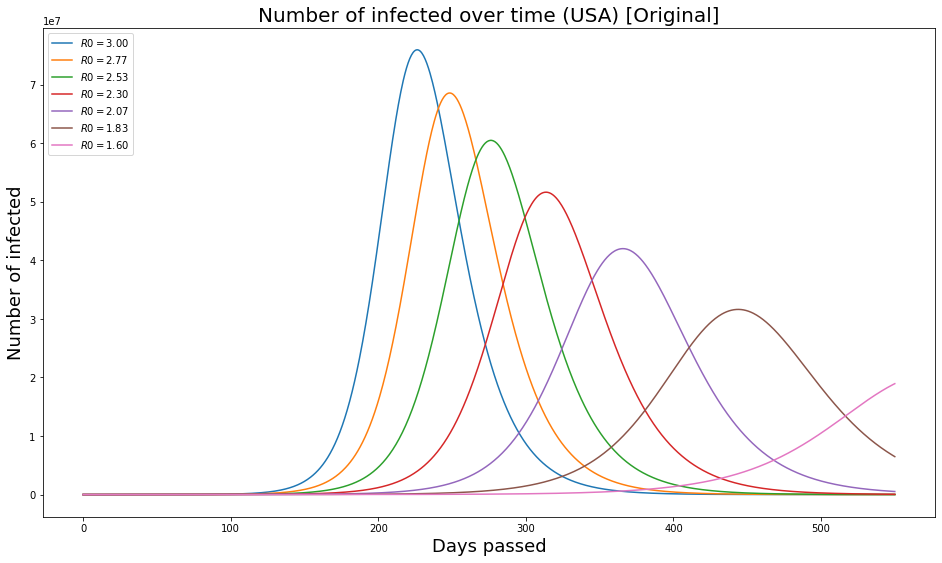

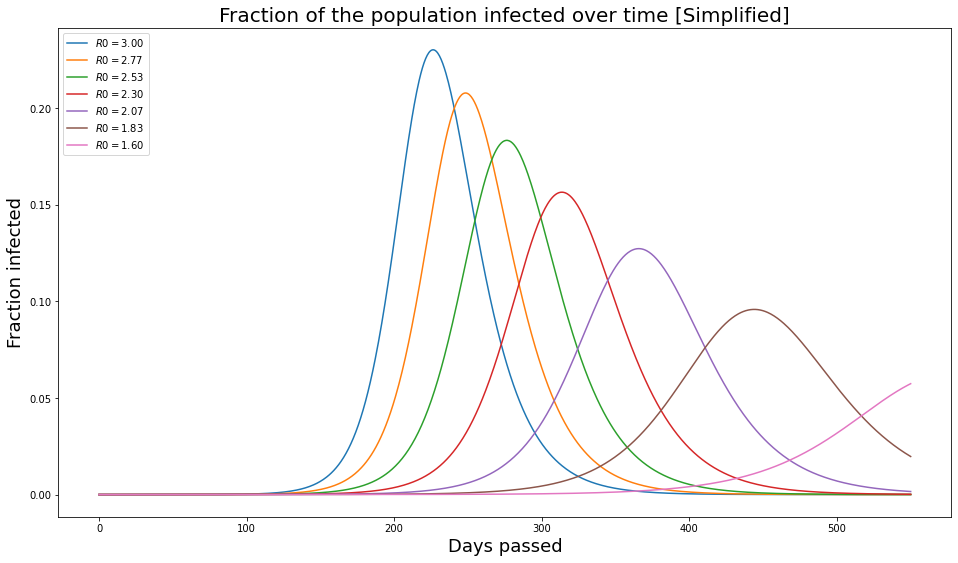

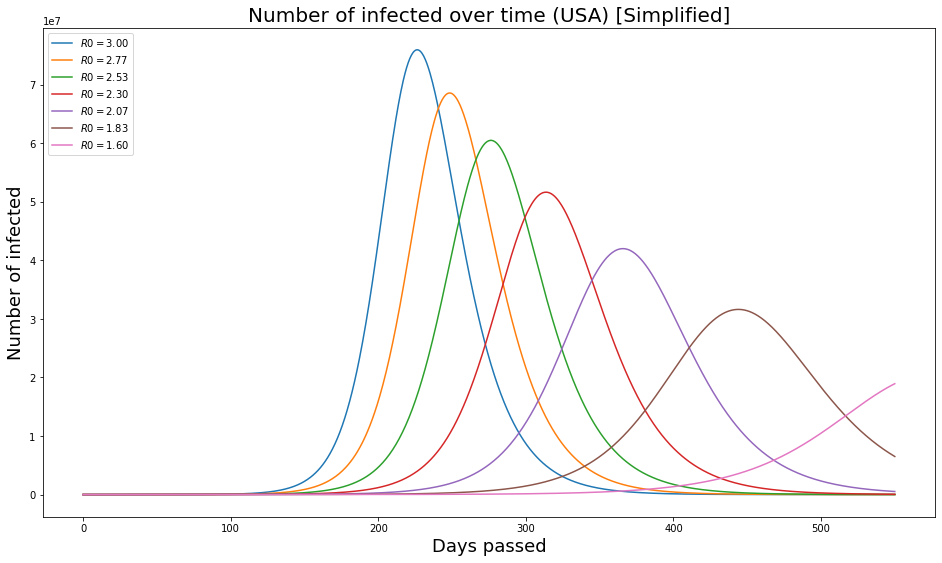

In [50]:
plot_paths(i_paths_o,
           labels,
           t_vec,
           title="Fraction of the population infected over time [Original]",
           x_label="Days passed",
           y_label="Fraction infected")

plot_paths([frac * population_size for frac in i_paths_o],
           labels,
           t_vec,
           title="Number of infected over time (USA) [Original]",
           x_label="Days passed",
           y_label="Number of infected")

plot_paths(i_paths_s,
           labels,
           t_vec,
           title="Fraction of the population infected over time [Simplified]",
           x_label="Days passed",
           y_label="Fraction infected")

plot_paths([frac * population_size for frac in i_paths_s],
           labels,
           t_vec,
           title="Number of infected over time (USA) [Simplified]",
           x_label="Days passed",
           y_label="Number of infected")

### Cumulative cases as a fraction of the population

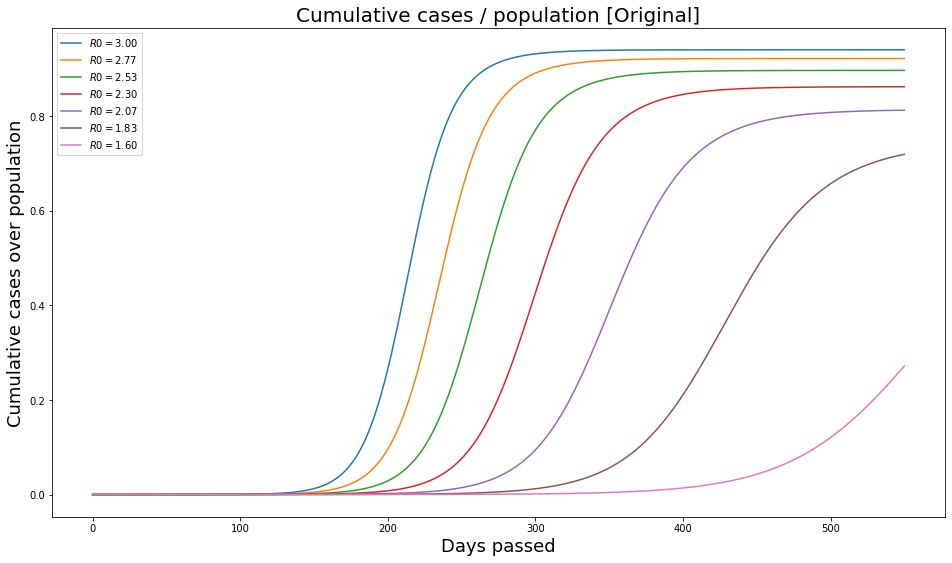

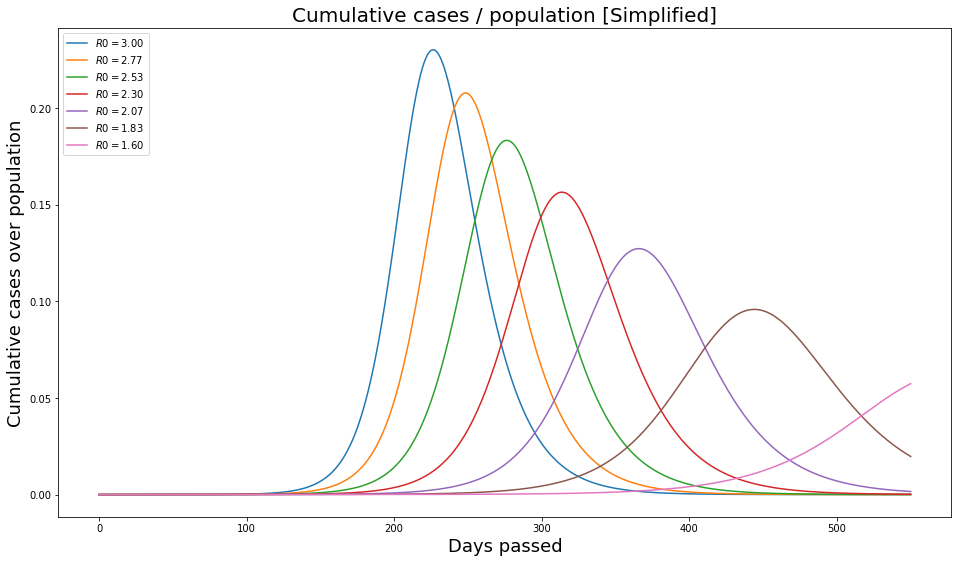

In [51]:
plot_paths(c_paths_o,
           labels,
           t_vec,
           title="Cumulative cases / population [Original]",
           x_label="Days passed",
           y_label="Cumulative cases over population")

plot_paths(c_paths_s,
           labels,
           t_vec,
           title="Cumulative cases / population [Simplified]",
           x_label="Days passed",
           y_label="Cumulative cases over population")

***
## Scenario 2: _R_0 with Mitigation

In this scenario, we are taking into account that some actions are being
taken (e.g. social distancing) to mitigate the virus spread.

In [52]:
def r0_mitigating(t, r0=3, restriction_rate=1, r_bar=1.6):
    r0 = r0 * np.exp(- restriction_rate * t) + (1 - np.exp(- restriction_rate * t)) * r_bar
    return r0

### _R_0 value over time with mitigation

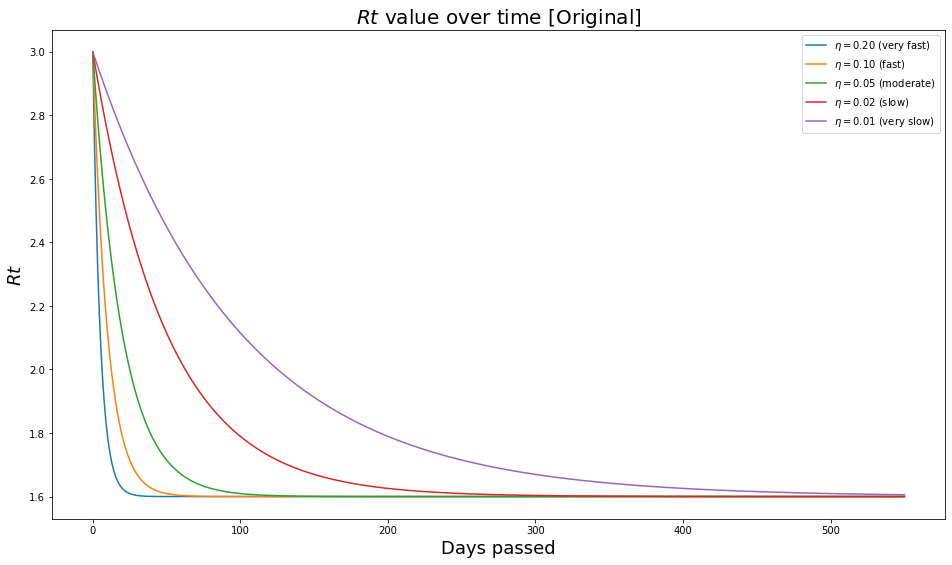

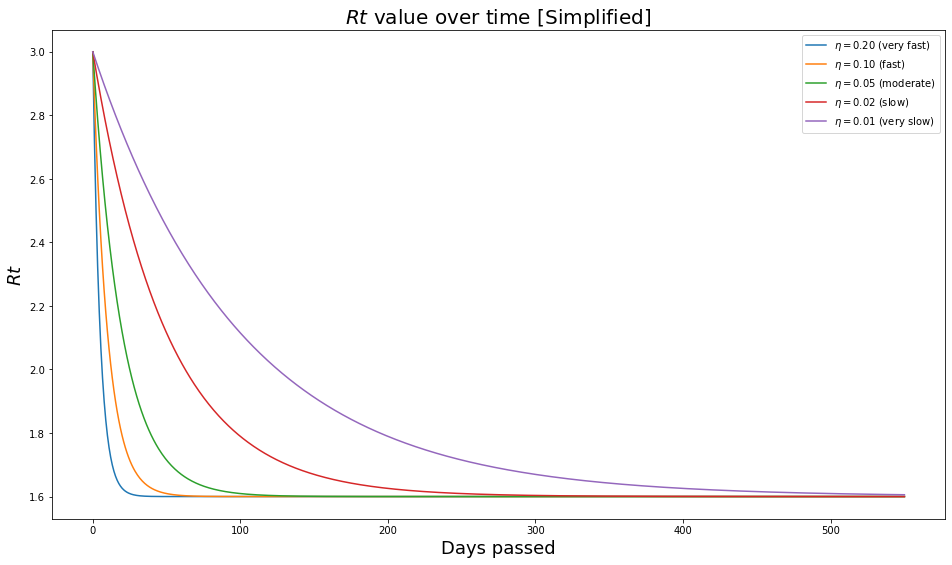

In [53]:
rr_vals = 1 / 5, 1 / 10, 1 / 20, 1 / 50, 1 / 100  # rr stands for Restriction Rate
rr_desc = "very fast", "fast", "moderate", "slow", "very slow"

labels = [fr'$\eta = {rr:.2f}$ ({rrdc})' for rr, rrdc in zip(rr_vals, rr_desc)]

rt_paths = [seir.solve_rt_path(3, 1.6, 3, 1.6, rr, rr, t_vec) for rr in rr_vals]
mitigated_path = (r0_mitigating(t_vec, restriction_rate=rr) for rr in rr_vals)

plot_paths(rt_paths,
           labels,
           t_vec,
           title="$Rt$ value over time [Original]",
           x_label="Days passed",
           y_label="$Rt$",
           legend_loc="upper right")

plot_paths(mitigated_path,
           labels,
           t_vec,
           title="$Rt$ value over time [Simplified]",
           x_label="Days passed",
           y_label="$Rt$",
           legend_loc="upper right")

### Current cases as a fraction of the population (with mitigation)

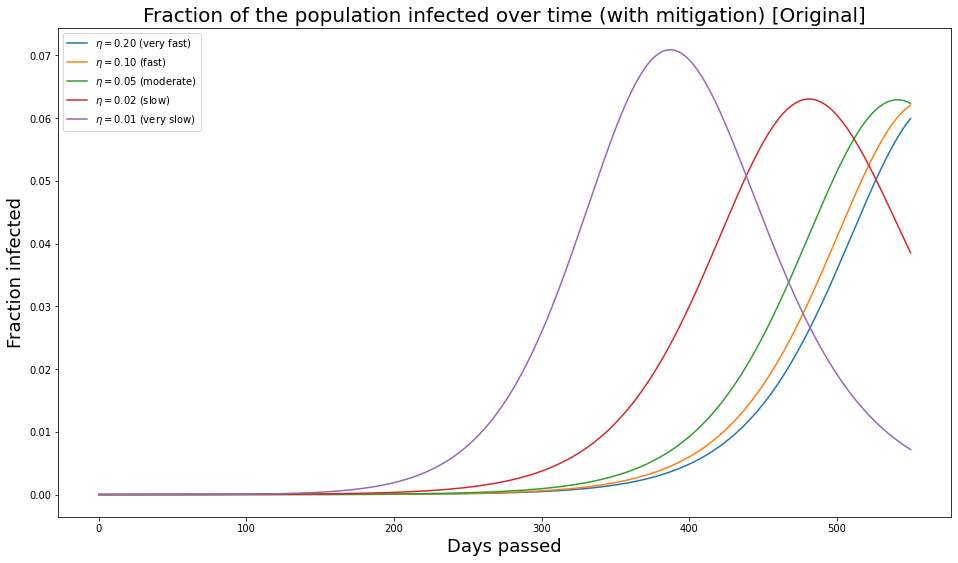

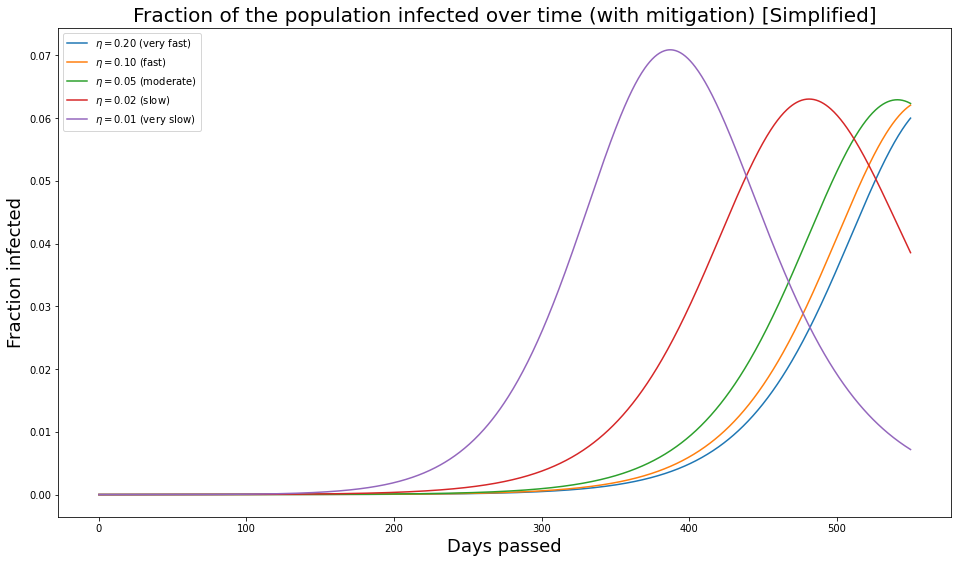

In [54]:
i_paths_o, c_paths_o = [], []
i_paths_s, c_paths_s = [], []

for rr in rr_vals:
    R0 = lambda t: r0_mitigating(t, restriction_rate=rr)  # TODO: replace lambda with something decent!

    i_path_o, c_path_o = seir.solve_path(incubation_period, illness_duration, x_0_o, t_vec, 3, 1.6, 3, 1.6, rr, rr)
    i_path_s, c_path_s = seir_smp.solve_path(R0, incubation_period, illness_duration, t_vec, x_0_s)

    i_paths_o.append(i_path_o)
    c_paths_o.append(c_path_o)
    i_paths_s.append(i_path_s)
    c_paths_s.append(c_path_s)

plot_paths(i_paths_o,
           labels,
           t_vec,
           title="Fraction of the population infected over time (with mitigation) [Original]",
           x_label="Days passed",
           y_label="Fraction infected")

plot_paths(i_paths_s,
           labels,
           t_vec,
           title="Fraction of the population infected over time (with mitigation) [Simplified]",
           x_label="Days passed",
           y_label="Fraction infected")

### Cumulative cases as a fraction of the population (with mitigation)

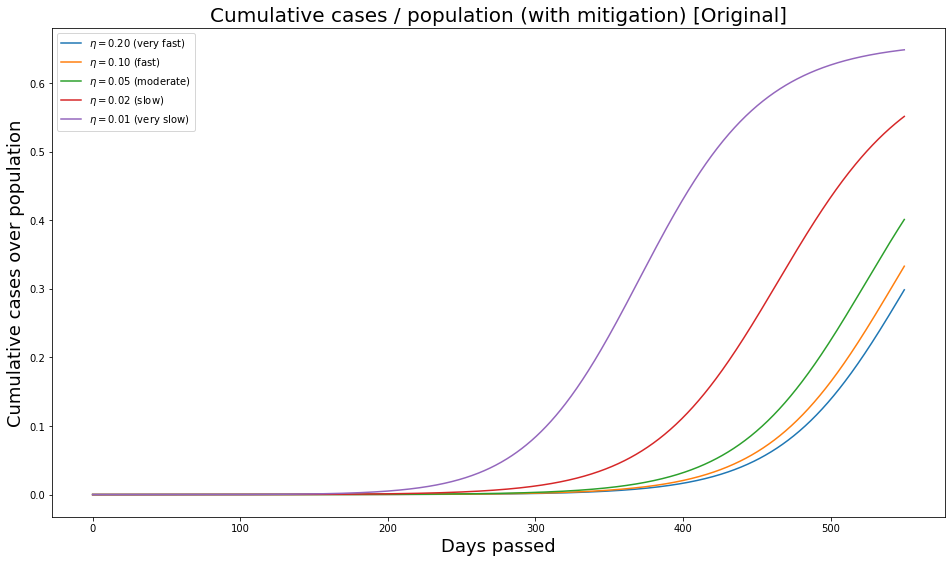

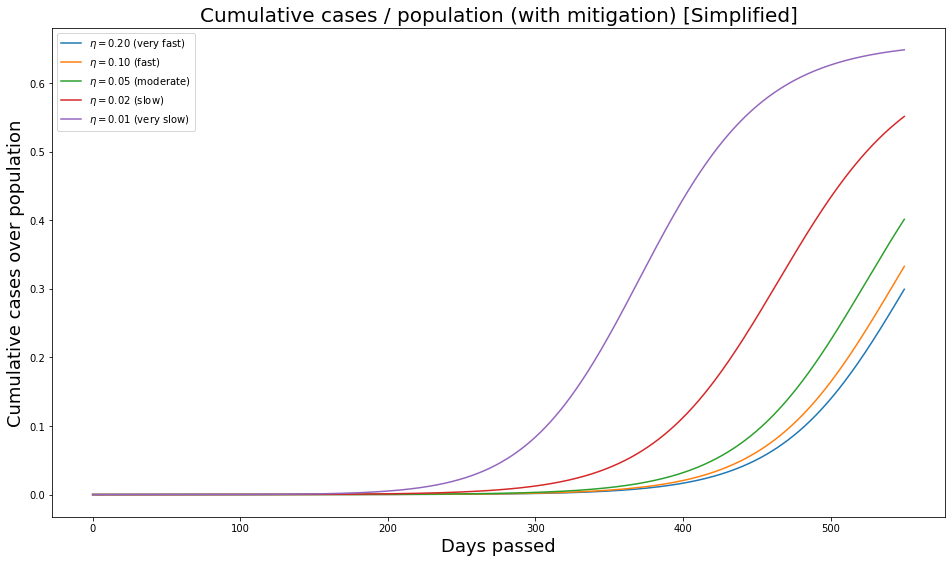

In [55]:
plot_paths(c_paths_o,
           labels,
           t_vec,
           title="Cumulative cases / population (with mitigation) [Original]",
           x_label="Days passed",
           y_label="Cumulative cases over population")

plot_paths(c_paths_s,
           labels,
           t_vec,
           title="Cumulative cases / population (with mitigation) [Simplified]",
           x_label="Days passed",
           y_label="Cumulative cases over population")

***
## Scenario 3: Lockdown
> Based in [Lockdowns and GDP
Is there a tradeoff?](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view)

In [56]:
# initial S, E, I
i_0 = 25_000 / population_size
e_0 = 75_000 / population_size
s_0 = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0

In [57]:
r0_paths = (2,
            lambda t: 0.5 if t < 30 else 2,
            lambda t: 0.5 if t < 120 else 2)

labels = [f'case {i + 1}' for i in range(len(r0_paths))]

i_paths, c_paths = [], []

for r0 in r0_paths:
    i_path, c_path = seir_smp.solve_path(r0, incubation_period, illness_duration, t_vec, x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

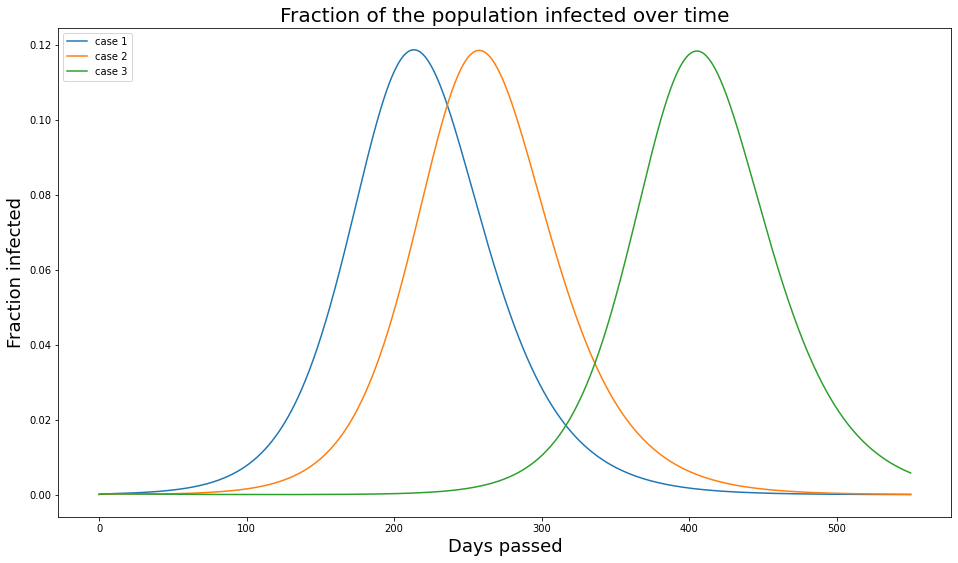

In [58]:
plot_paths(i_paths,
           labels,
           t_vec,
           title="Fraction of the population infected over time",
           x_label="Days passed",
           y_label="Fraction infected")

In [59]:
death_rate = 0.01

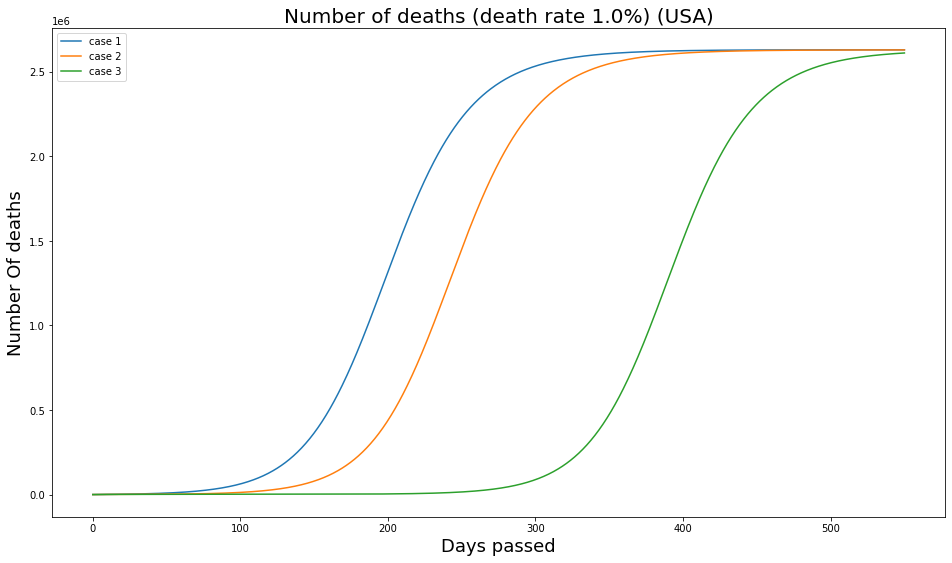

In [60]:
plot_paths([path * death_rate * population_size for path in c_paths],
           labels,
           t_vec,
           title=f"Number of deaths (death rate {death_rate * 100}%) (USA)",
           x_label="Days passed",
           y_label="Number Of deaths")

---
## Scenario 4: Temporary extremely severe mitigation measures

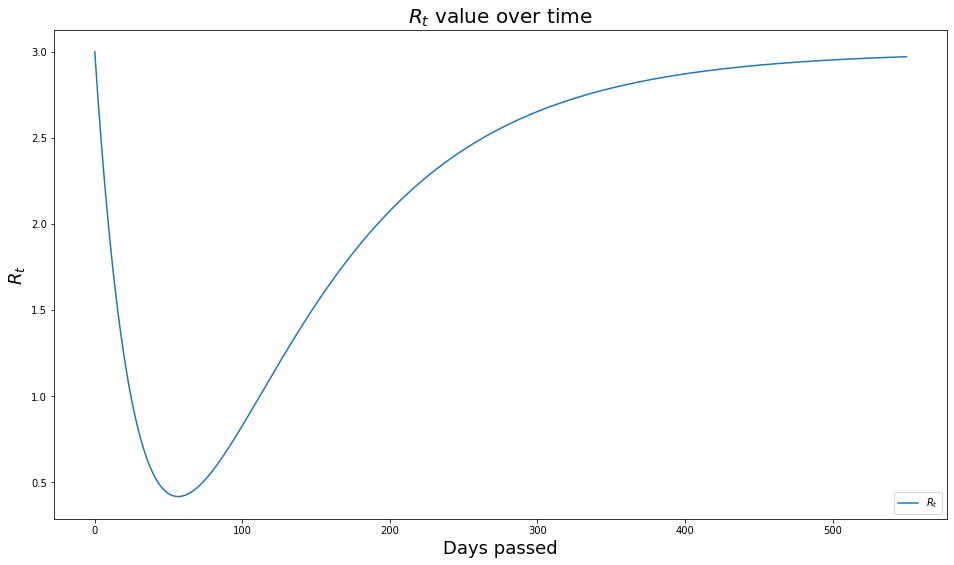

In [61]:
rt_path = seir.solve_rt_path(10,
                             -4,
                             -4,
                             10,
                             1 / 35,
                             1 / 100,
                             t_vec)

plot_path(rt_path,
          "$ R_t $",
          t_vec,
          title="$ R_t $ value over time",
          x_label="Days passed",
          y_label="$ R_t $",
          legend_loc="lower right")